# HH analysis

This notebook provides the necessary tools to produce the $HH\rightarrow b\bar{b} g g$ and $HH\rightarrow b\bar{b} W^+ W^-$ analysis. Firstly, let's import some useful python modules

In [1]:
import treeloop.looper as l
import treeloop.configvar as cv
import treeloop.configsel as cs
import numpy as np
import awkward as ak

In [2]:
jets_name='AKTjet'
jets_vars = ['.PT', '.Eta', '.Phi', '.Mass', '.BTag', '_size']

loopers = {
    'sig' : l.looper('Delphes',
                     ['../files/events/sig_test.root'],
                     branches=[f'{jets_name}{v}' for v in jets_vars],
                    ),
    'bkg' : l.looper('Delphes',
                     ['../files/events/tag_1_pythia8_events.delphes.root'],
                     branches=[f'{jets_name}{v}' for v in jets_vars],
                    ),
}

# Variables
jet_n    = lambda event,sel_name=None: cv.var(event,f'{jets_name}_size',sel_name=sel_name)
jet_pt   = lambda event,sel_name=None: cv.var(event,f'{jets_name}.PT',sel_name=sel_name)
jet_eta  = lambda event,sel_name=None: cv.var(event,f'{jets_name}.Eta',sel_name=sel_name)
jet_phi  = lambda event,sel_name=None: cv.var(event,f'{jets_name}.Phi',sel_name=sel_name)
jet_mass = lambda event,sel_name=None: cv.var(event,f'{jets_name}.Mass',sel_name=sel_name)
jet_btag = lambda event,sel_name=None: cv.var(event,f'{jets_name}.BTag',sel_name=sel_name)
jet_i    = lambda event,sel_name=None: ak.argsort(ak.argsort(jet_pt(event,sel_name=sel_name), ascending=False))

def jets_b_match(event, to_match, sel_name=None):
    b_jets=jet_btag(event, sel_name=sel_name)
    ret=None
    for t in to_match:
        _pass = (b_jets == t)
        if ret is None: ret = _pass
        else: ret = ret+ _pass
    return ret

jets_b_loo = lambda event, sel_name=None: jets_b_match(event, [4,5,6,7], sel_name=None)
jets_b_med = lambda event, sel_name=None: jets_b_match(event, [2,3,6,7], sel_name=None)
jets_b_tig = lambda event, sel_name=None: jets_b_match(event, [1,3,5,7], sel_name=None)

ntag_loo = lambda event, sel_name=None: ak.count_nonzero(jets_b_loo(event,sel_name=sel_name),axis=1)
ntag_med = lambda event, sel_name=None: ak.count_nonzero(jets_b_med(event,sel_name=sel_name),axis=1)
ntag_tig = lambda event, sel_name=None: ak.count_nonzero(jets_b_tig(event,sel_name=sel_name),axis=1)

# Selections
sel_ntag_loo_two = lambda event,**kwargs: ntag_loo(event)==2
sel_ntag_loo_two.__name__ = "sel_ntag_loo_two"

sel_two_jet = lambda event, **kwargs: jet_n(event) >= 2
sel_two_jet.__name__ = "sel_two_jet"


In [3]:
def jet_vectors(event, sel_name=None):
    pt   = jet_pt(event, sel_name=sel_name)
    eta  = jet_eta(event, sel_name=sel_name)
    phi  = jet_phi(event, sel_name=sel_name)
    mass = jet_mass(event, sel_name=sel_name)

    import vector as v
    return v.zip({'pt':pt,'eta':eta,'phi':phi,'mass':mass})


#jet_vecs = looper.variable(jet_vectors)
#jetsel_b = looper.variable(jets_b_tig)
#sel = ak.count_nonzero(jetsel_b, axis=1) == 2
#et_vecs_b_loo = jet_vecs[jetsel_b][sel]


In [4]:
# main_sel=cs.baseline
main_sel =sel_two_jet

vars_dict = {
    #Useful variables
    'jets_b_loo' : jets_b_loo,
    'jets_b_med' : jets_b_med,
    'jets_b_tig' : jets_b_tig,
    'ntag_loo'   : ntag_loo,
    'ntag_med'   : ntag_med,
    'ntag_tig'   : ntag_tig,
    'jet_pt'     : jet_pt,
    'jet_eta'    : jet_eta,
    'jet_phi'    : jet_phi,
    'jet_mass'   : jet_mass,
    'jet_i'      : jet_i,
    'jets_4vect' : jet_vectors,
}

vals = {sample_name: loop.variables(vars_dict,selection=main_sel) for sample_name,loop in loopers.items()}

leadjet_descr = {'fir': 0, 'sec': 1, 'thi': 2, 'fou': 3}

sels = {
    sample: {
            f'sel_{jname}_jet': (vals[sample]['jet_i'][0] == index) 
            for jname,index in leadjet_descr.items()
        } for sample in vals.keys()
}

for sample in vals.keys():
    for _v in ['pt','eta','phi','mass']:
        for jname in leadjet_descr.keys():
            vals[sample][f'{jname}jet_{_v}'] = [ak.flatten(vals[sample][f'jet_{_v}'][i][sels[sample][f'sel_{jname}_jet']],axis=1) for i in [0,1]]

In [5]:
vals['sig']['secjet_pt'][1]

<Array [1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1] type='6712 * float32'>

## Quick plots

In [6]:
import matplotlib.pyplot as plt

def getAdaptiveBinning(*argv,bins=None,range=None,ncounts=5,**kwargs):
    assert bins is not None, 'Please specify bins argument for getAdaptiveBinning(...)'
    assert range is not None, 'Please specify range argument for getAdaptiveBinning(...)'
    dx = abs(range[1]-range[0])/float(bins)
    x_low = range[0]
    x_high = range[0]
    binning=[]

    while x_low <= range[1]:
        print(binning)
        binning+=[x_low]
        i=0
        _next_step=True
        while _next_step and x_high < range[1]:
            i+=1
            x_high = x_low + i*dx
            for vals in argv:
                _counts = ak.sum((vals>x_low) * (vals <= x_high) )
                if _counts < ncounts:
                    _next_step=False
                    break
        x_low=x_high
    if binning[-1]!=range[1]:
        binning[-1]=range[1]
    return binning

def makeHistComp(vals_sig,vals_bkg,doAdaptiveBinning=False,*args,**kwargs):
    fig = plt.figure(figsize=(12, 8))
    # bins = getAdaptiveBinning(vals_sig, vals_bkg, **kwargs)
    # print(bins)
    h_sig = plt.hist(vals_sig, *args, histtype='step', label='Signal', **kwargs)
    h_bkg = plt.hist(vals_bkg, *args, histtype='step', label='Background', **kwargs)
    # plt.xlabel('ntag')
    plt.legend()
    plt.show()

    return h_sig, h_bkg


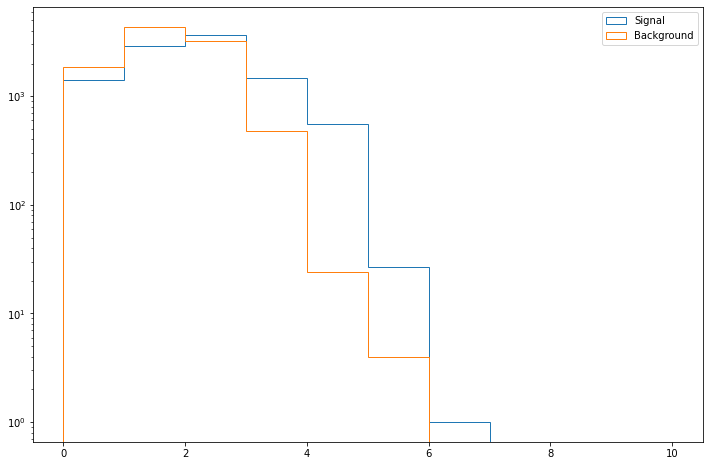

In [7]:
varname = 'ntag_loo'
h_sig,h_bkg = makeHistComp(vals['sig'][varname][0], vals['bkg'][varname][0],
                           bins=10, 
                           density=False, 
                           range=(0, 10), 
                           doAdaptiveBinning=True,
                           log=True)


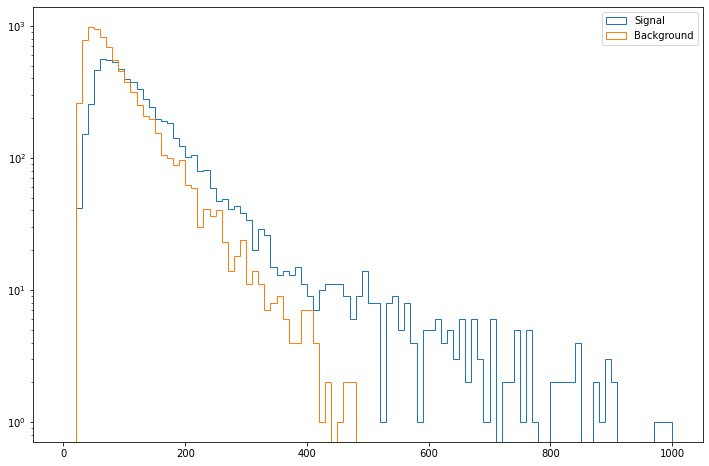

In [120]:
varname = 'firjet_pt'
h_sig, h_bkg = makeHistComp(vals['sig'][varname][0], vals['bkg'][varname][0],
                            bins=100,
                            density=False,
                            range=(0, 1000),
                            log=True)


In [40]:
h_sig[0]

array([1.396e+03, 2.898e+03, 3.662e+03, 1.465e+03, 5.510e+02, 2.700e+01,
       1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00])

## Statistical interpretation

In [52]:
def testSignificance(bkg,sgn,systs=None, ntoys=2000):

    import pyhf
    pyhf.set_backend(pyhf.tensorlib, 'minuit')
    import scipy.stats as st

    data = [s+b for s,b in zip(sgn,bkg)]


    model = pyhf.simplemodels.uncorrelated_background(
        signal=sgn, 
        bkg=bkg, 
        bkg_uncertainty=systs if systs is not None else [0. for x in bkg] #no systematics
    )
    print(f'Testing significance for sgn={sgn} and bkg={bkg}')

    obs = data + model.config.auxdata
    test_mu = 0.0
    pval = pyhf.infer.hypotest(test_mu, obs, model, test_stat="q0", calctype='toybased', ntoys=ntoys)
    sig = st.norm.isf(pval)
    return pval,sig

In [53]:
testSignificance([6400.],[3*80.]) #this should give 3 sigma significance

/Users/valentem/cernbox/Projects/hepgenchain/venv/lib/python3.9/site-packages/pyhf/optimize/opt_minuit.py:136: IMinuitWarning: Hesse called with all parameters fixed
  minimizer.hesse()


Testing significance for sgn=[240.0] and bkg=[6400.0]


(array(0.0025), 2.8070337683438042)

In [49]:
testSignificance(list(h_bkg[0])[:5],[x/100. for x in h_sig[0]][:5])

Testing significance for sgn=[13.96, 28.98, 36.62, 14.65, 5.51] and bkg=[1876.0, 4366.0, 3247.0, 483.0, 24.0]


(array(0.0565), 1.5848518438340828)

## Classifier

In [36]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier

In [143]:

scaler = MinMaxScaler()

rows_to_sel = ['ntag_tig', 'ntag_med','firjet_pt','firjet_eta','secjet_pt','secjet_pt']

df_X = ak.to_pandas({f'{sample}': { 
                        f'{rowname}': vals[sample][rowname][0] 
                        for rowname in rows_to_sel
                        } 
                   for sample in ['sig','bkg']
                   })
_N = df_X.shape[0]
df_y = pd.DataFrame({'sig':[1]*_N,
                     'bkg':[0]*_N 
                    })

df_w = pd.DataFrame({'sig':[0.1]*_N,
                     'bkg':[0.7]*_N 
                   })

df_X = pd.concat([df_X['sig'], df_X['bkg']])
df_y = pd.concat([df_y['sig'], df_y['bkg']])
df_w = pd.concat([df_w['sig'], df_w['bkg']])

print(_N)
print(df_X.shape[0])
print(df_X.shape[0]/_N)

# n_train = round(df.shape[0]/2)
# X_train = scaler.fit_transform(df.values[:n_train])
# X_test  = scaler.transform(df.values[n_train:])


6712
13424
2.0


In [150]:
state = 12
test_size = 0.20

X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(df_X, df_y, df_w,
                                                  test_size=test_size, random_state=state)

lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(
        n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gb_clf.fit(X_train, y_train, sample_weight=w_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(
        gb_clf.score(X_train, y_train, sample_weight=w_train)))
    print("Accuracy score (validation): {0:.3f}".format(
        gb_clf.score(X_val, y_val, sample_weight=w_val)))

gb_clf2 = GradientBoostingClassifier(
    n_estimators=20, learning_rate=0.5, max_features=2, max_depth=2, random_state=0)
gb_clf2.fit(X_train, y_train,sample_weight=w_train)
predictions = gb_clf2.predict(X_val)
predictions_prob = gb_clf2.predict_proba(X_val)
decision_func = gb_clf2.decision_function(X_val)
scores = gb_clf2.score(X_val, y_val, sample_weight=w_val)
# print(predictions)
# print(scores,)
print(decision_func)

print("Confusion Matrix:")
print(confusion_matrix(y_val, predictions, sample_weight=w_val))

print("Classification Report")
print(classification_report(y_val, predictions, sample_weight=w_val))



Learning rate:  0.05
Accuracy score (training): 0.879
Accuracy score (validation): 0.884
Learning rate:  0.075
Accuracy score (training): 0.882
Accuracy score (validation): 0.887
Learning rate:  0.1
Accuracy score (training): 0.889
Accuracy score (validation): 0.892
Learning rate:  0.25
Accuracy score (training): 0.898
Accuracy score (validation): 0.903
Learning rate:  0.5
Accuracy score (training): 0.904
Accuracy score (validation): 0.904
Learning rate:  0.75
Accuracy score (training): 0.906
Accuracy score (validation): 0.900
Learning rate:  1
Accuracy score (training): 0.904
Accuracy score (validation): 0.899
[ 2.23686442 -1.57455321 -2.09976398 ... -1.85586336  3.24341917
 -1.23262754]
Confusion Matrix:
[[949.9  11.9]
 [ 93.5  37.6]]
Classification Report
              precision    recall  f1-score   support

           0       0.91      0.99      0.95 961.8000000000234
           1       0.76      0.29      0.42 131.09999999999684

    accuracy                           0.90 1092.9

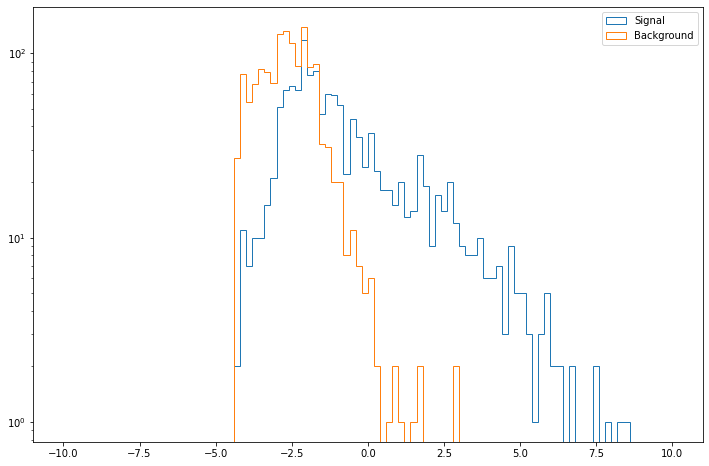

In [157]:
h_sig, h_bkg = makeHistComp(decision_func[y_val == 1], decision_func[y_val == 0],
                            bins=100,
                            density=False,
                            range=(-10, 10),
                            log=True)


In [126]:
state = 12
test_size = 0.20

X_train, X_val, y_train, y_val = train_test_split(df_X, df_y,
                                                  test_size=test_size, random_state=state)


rf_clf = RandomForestClassifier(
    n_estimators=100)
    # learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
rf_clf.fit(X_train, y_train)
y_pred=rf_clf.predict(X_val)

print("Learning rate: ", learning_rate)
print("Accuracy score (training): {0:.3f}".format(
    rf_clf.score(X_train, y_train)))
print("Accuracy score (validation): {0:.3f}".format(
    rf_clf.score(X_val, y_val)))

print('Predictions:')
print(y_pred)


# gb_clf2 = GradientBoostingClassifier(
#     n_estimators=20, learning_rate=0.5, max_features=2, max_depth=2, random_state=0)
# gb_clf2.fit(X_train, y_train)
# predictions = gb_clf2.predict(X_val)
# print(np.sum(predictions))

# print("Confusion Matrix:")
# print(confusion_matrix(y_val, predictions))

# print("Classification Report")
# print(classification_report(y_val, predictions))


Learning rate:  1
Accuracy score (training): 1.000
Accuracy score (validation): 0.714
Predictions:
[1 0 1 ... 0 1 1]


In [44]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)

score = xgb_clf.score(X_val, y_val)
print(score)


ModuleNotFoundError: No module named 'xgboost'